In [250]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#
import torch.nn as nn
from torch import optim
#
import numpy as np

In [2]:
ds_train = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
ds_valid = datasets.MNIST(root="./data", train=False, download=True, transform=T.ToTensor())

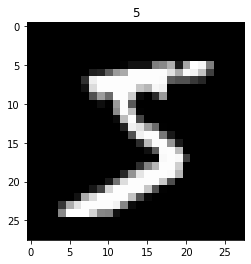

In [3]:
plt.imshow(ds_train.data[0], cmap='gray')
plt.title('%i' % ds_train.targets[0])
plt.show()

In [4]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=4)

# Baseline CNN for MNIST

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization

In [6]:
model = CNN()

In [7]:
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [8]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for idx, (x, y_true) in enumerate(dl_train):
        y_pred = model(x)
        loss = loss_func(y_pred, y_true)

        # clear gradients for this training step   
        optimizer.zero_grad()           
            
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()
        
        if idx % 1000 == 0:
            print("Epoch[{}/{}] - step {} loss: {:.4f}".format(epoch, num_epochs, idx, loss.item()))

Epoch[0/10] - step 0 loss: 2.3103
Epoch[1/10] - step 0 loss: 0.0192
Epoch[2/10] - step 0 loss: 0.0665
Epoch[3/10] - step 0 loss: 0.0174
Epoch[4/10] - step 0 loss: 0.0290
Epoch[5/10] - step 0 loss: 0.0264


KeyboardInterrupt: 

In [345]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x, y_true in dl_valid:
        y_pred = model(x)
        y_pred = torch.max(y_pred, 1)[1]
        correct += (y_pred == y_true).sum().item()
        total += y_true.shape[0]
    acc = correct / total

In [346]:
print(acc)
print(total - correct)

0.9895
105


# Eff-Caps

In [342]:
class PrimaryCaps(nn.Module):
    """
        Create a primary capsule layer with the methodology described in 'Efficient-CapsNet: Capsule Network with Self-Attention Routing'. 
        Properties of each capsule s_n are exatracted using a 2D depthwise convolution.

        ...

        Attributes
        ----------
        F: int depthwise conv number of features
        K: int depthwise conv kernel dimension 
        N: int number of primary capsules
        D: int primary capsules dimension (number of properties)
        s: int depthwise conv strides
    """
    def __init__(self, F, K, N, D, s=1):
        super().__init__()
        self.F = F
        self.K = K
        self.N = N
        self.D = D
        self.s = s
        #
        self.dw_conv2d = nn.Conv2d(F, F, kernel_size=K, stride=s, groups=F, padding="valid")
        #
    def forward(self, x):
        """
         X in (B,C,H,W) = (B,F,K,K)
         -> (B, N, D)
        """
        # (B,C,H,W) -> (B,C,H,W)
        x = self.dw_conv2d(x)

        # (B,C,H,W) -> (B, N, D)
        x = x.view((-1, self.N, self.D))
        
        #
        return x

class Squash(nn.Module):
    def __init__(self, eps=10e-21):
        super().__init__()
        self.eps = eps
    def forward(self, x):
        """
         in:  (b, n, d)
         out: (b, n, d)
        """
        xn = torch.norm(x, dim=2, keepdim=True)
        return (1 - 1/(torch.exp(xn) + self.eps)) * (x / (xn + eps))

class FCCaps(nn.Module):
    def __init__(self, n_l, n_h, d_l, d_h):
        super().__init__()
        self.n_l = n_l
        self.d_l = d_l
        self.n_h = n_h
        self.d_h = d_h
        #
        self.W = torch.nn.Parameter(torch.rand(n_l, n_h, d_l, d_h))
        self.B = torch.nn.Parameter(torch.rand(n_l, n_h))
        self.squash = Squash()

    def forward(self, U_l):
        """
        einsum convenventions:
          n_l = i | h
          d_l = j
          n_h = k
          d_h = l
        
        Data tensors:
            IN:  U_l
            OUT: U_h
            DIMS: 
                U_l (n_l, d_l)
                U_h (n_h, d_h)
                W   (n_l, n_h, d_l, d_h)
                B   (n_l, n_h)
                A   (n_l, n_l, n_h)
                C   (n_l, n_h)
        """
        U_hat = torch.einsum('...ij,ikjl->...ikl', U_l, self.W)
        A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
        A = A / torch.sqrt(torch.Tensor([d_l]))
        A_sum = torch.einsum("...hij->...hj",A)
        C = torch.softmax(A_sum,dim=-1)
        CB = C + self.B
        U_h = torch.einsum('...ikl,...ik->...kl', U_hat, CB)
        return self.squash(U_h)



class EfficientCapsNets(nn.Module):
    def __init__(self):
        super().__init__()
    def call(self, x):
        pass

In [347]:
# CNN Part
# add he normal initializer
cn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(5, 5), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=(3, 3), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=(3, 3), padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=2, padding="valid"),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
)
x_h = cn(x)
print(x_h.shape)

torch.Size([16, 128, 9, 9])


In [353]:
n_l = 16
d_l = 8
#
n_h = 10
d_h = 8

In [354]:
pc = PrimaryCaps(F=128, K=9, N=n_l, D=d_l)
#
U_0 = pc(x_h)
print(U_0.shape)

torch.Size([16, 16, 8])


In [356]:
fcn = FCCaps(n_l, n_h, d_l, d_h)
#
U_1 = fcn(U_0)

In [357]:
U_1.shape

torch.Size([16, 10, 8])

# TensorFlow Stuff

In [ ]:
class Length(tf.keras.layers.Layer):
    """
    Compute the length of each capsule n of a layer l.
    ...
    
    Methods
    -------
    call(inputs)
        compute the length of each capsule
    """

    def call(self, inputs, **kwargs):
        """
        Compute the length of each capsule
        
        Parameters
        ----------
        inputs: tensor
           tensor with shape [None, num_capsules (N), dim_capsules (D)]
        """
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), - 1) + tf.keras.backend.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

class Mask(tf.keras.layers.Layer):
    """
    Mask operation described in 'Dynamic routinig between capsules'.
    
    ...
    
    Methods
    -------
    call(inputs, double_mask)
        mask a capsule layer
        set double_mask for multimnist dataset
    """
    def call(self, inputs, double_mask=None, **kwargs):
        if type(inputs) is list:
            if double_mask:
                inputs, mask1, mask2 = inputs
            else:
                inputs, mask = inputs
        else:  
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            if double_mask:
                mask1 = tf.keras.backend.one_hot(tf.argsort(x,direction='DESCENDING',axis=-1)[...,0],num_classes=x.get_shape().as_list()[1])
                mask2 = tf.keras.backend.one_hot(tf.argsort(x,direction='DESCENDING',axis=-1)[...,1],num_classes=x.get_shape().as_list()[1])
            else:
                mask = tf.keras.backend.one_hot(indices=tf.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        if double_mask:
            masked1 = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask1, -1))
            masked2 = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask2, -1))
            return masked1, masked2
        else:
            masked = tf.keras.backend.batch_flatten(inputs * tf.expand_dims(mask, -1))
            return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # generation step
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config